The analysis focused on identifying the best-performing regression model for predicting automobile prices based on various features.

<hr/>
Importing Libraries

In [75]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

<hr/>
Reading dataset

In [16]:
dataframe = pd.read_csv("./ford.csv")
print('Initial dataframe:')
print(dataframe)

Initial dataframe:
         model  year  price transmission  mileage fuelType  tax   mpg  \
0       Fiesta  2017  12000    Automatic    15944   Petrol  150  57.7   
1        Focus  2018  14000       Manual     9083   Petrol  150  57.7   
2        Focus  2017  13000       Manual    12456   Petrol  150  57.7   
3       Fiesta  2019  17500       Manual    10460   Petrol  145  40.3   
4       Fiesta  2019  16500    Automatic     1482   Petrol  145  48.7   
...        ...   ...    ...          ...      ...      ...  ...   ...   
17961    B-MAX  2017   8999       Manual    16700   Petrol  150  47.1   
17962    B-MAX  2014   7499       Manual    40700   Petrol   30  57.7   
17963    Focus  2015   9999       Manual     7010   Diesel   20  67.3   
17964       KA  2018   8299       Manual     5007   Petrol  145  57.7   
17965    Focus  2015   8299       Manual     5007   Petrol   22  57.7   

       engineSize  
0             1.0  
1             1.0  
2             1.0  
3             1.5  
4   

<hr/>
Implementing one-hot encoding technique

In [43]:
dataframe = pd.get_dummies(dataframe, columns=['model','transmission','fuelType'])

<hr/>
Data cleaning process

In [44]:
# Duplicated entries
duplicated_entries = dataframe[dataframe.duplicated(keep=False)]

# Missing values
missing_values = dataframe.isnull().sum()

print('The number of duplicated entries: ', len(duplicated_entries))
print('Duplicated entries: ', duplicated_entries)
print('Missing values: ', missing_values)

The number of duplicated entries:  302
Duplicated entries:         year  price  mileage  tax   mpg  engineSize  model_ B-MAX  \
25     2017  18499    13063  145  41.5         2.0         False   
27     2015   8299    25935    0  65.7         1.0         False   
28     2018  12499     8700  145  58.9         1.0         False   
113    2016  10995    30923    0  74.3         1.5         False   
159    2016  10995    30923    0  74.3         1.5         False   
...     ...    ...      ...  ...   ...         ...           ...   
15127  2019  16799      433  150  45.6         1.0         False   
15684  2008   1795    63000  160  45.6         1.3         False   
15685  2008   1795    63000  160  45.6         1.3         False   
17607  2017  11495     5000  145  44.1         1.6          True   
17608  2017  11495     5000  145  44.1         1.6          True   

       model_ C-MAX  model_ EcoSport  model_ Edge  ...  \
25            False            False        False  ...   
27     

<hr/>
As you can see there is no missing values. But there are 302 duplicated entries.
<br/>
I'll drop duplicated entries while keeping one of them



In [49]:
dataframe = dataframe.drop_duplicates(keep='first')

print("Dropping duplicated entries...")

# Double checking
duplicated_entries = dataframe[dataframe.duplicated(keep=False)]
print('The number of duplicated entries: ', len(duplicated_entries))

print("Updated dataframe:")
print(dataframe)

Dropping duplicated entries...
The number of duplicated entries:  0
Updated dataframe:
       year  price  mileage  tax   mpg  engineSize  model_ B-MAX  \
0      2017  12000    15944  150  57.7         1.0         False   
1      2018  14000     9083  150  57.7         1.0         False   
2      2017  13000    12456  150  57.7         1.0         False   
3      2019  17500    10460  145  40.3         1.5         False   
4      2019  16500     1482  145  48.7         1.0         False   
...     ...    ...      ...  ...   ...         ...           ...   
17961  2017   8999    16700  150  47.1         1.4          True   
17962  2014   7499    40700   30  57.7         1.0          True   
17963  2015   9999     7010   20  67.3         1.6         False   
17964  2018   8299     5007  145  57.7         1.2         False   
17965  2015   8299     5007   22  57.7         1.0         False   

       model_ C-MAX  model_ EcoSport  model_ Edge  ...  \
0             False            False  

<hr/>
Exploratory Data Analysis: The number of sales for each fuel type

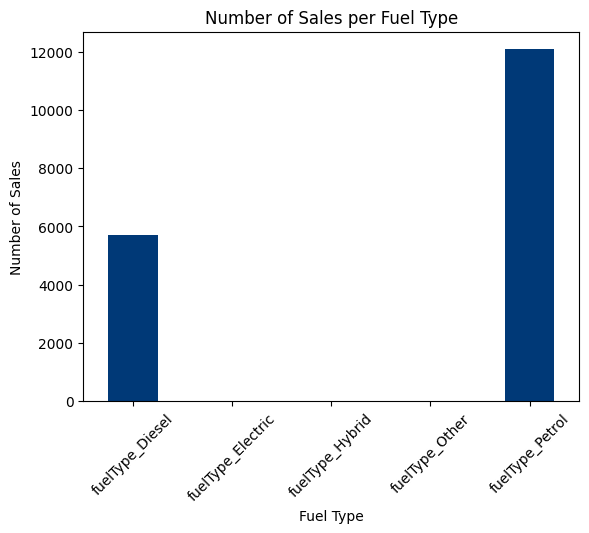


Number of sales per Fuel Type:
fuelType_Diesel       5706
fuelType_Electric        2
fuelType_Hybrid         22
fuelType_Other           1
fuelType_Petrol      12081
dtype: int64


In [53]:
# Counting the values by 'fuelType' column
sales_per_fuel_type = dataframe.filter(like='fuelType').sum()

# Plotting
sales_per_fuel_type.plot(kind='bar', color='#003977')
plt.title('Number of Sales per Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.show()

print("\nNumber of sales per Fuel Type:")
print(sales_per_fuel_type)

<hr/>
Exploratory Data Analysis: Identifying which transmission type has more price outliers

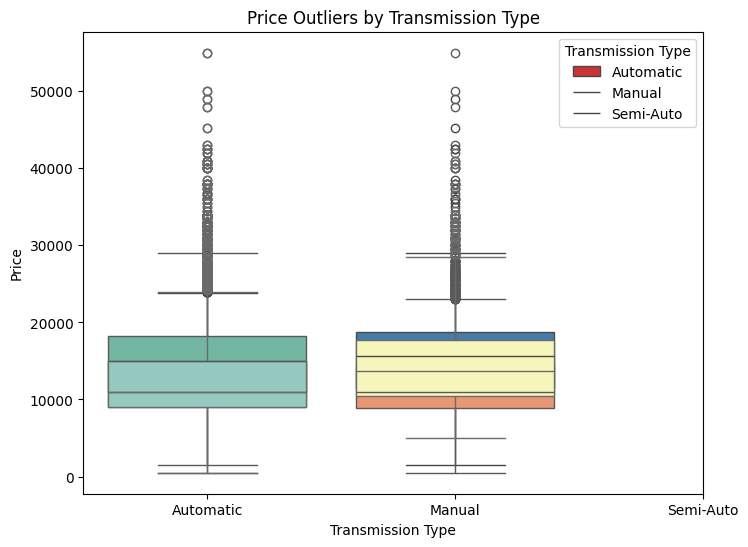

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(x='transmission_Automatic', y='price', data=dataframe, palette='Set1')
sns.boxplot(x='transmission_Manual', y='price', data=dataframe, palette='Set2')
sns.boxplot(x='transmission_Semi-Auto', y='price', data=dataframe, palette='Set3')
plt.title('Price Outliers by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.xticks([0, 1, 2], ['Automatic', 'Manual', 'Semi-Auto'])
plt.legend(title='Transmission Type', loc='upper right', labels=['Automatic', 'Manual', 'Semi-Auto'])
plt.show()


<hr/>
To find best-performing model, we will try <b>Linear</b>, <b>Polynomial</b> and <b>Ridge</b> regression models.
<br/>
Then evaluate each of their's performance.
<br/>
First I'll define the function which evaulates model by receiving the model, input and output data.
<br/>

In [65]:
# Evaluates models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Preparing input and output
X = dataframe.drop('price', axis=1)
y = dataframe['price']

<hr/>
Linear regression

In [67]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regressor model
linear_reg = LinearRegression()

# Training linear regressor
linear_reg.fit(X_train, y_train)

# Evaluating
linear_mse, linear_r2 = evaluate_model(linear_reg, X_test, y_test)
print("Linear Regression Result")
print("Mean Squared Error:", linear_mse)
print("R-squared Score:", linear_r2)

Linear Regression Result
Mean Squared Error: 4060994.7939468143
R-squared Score: 0.8188919779971316


<hr/>
Ridge regression

In [70]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge regressor model
ridge_reg = Ridge(alpha=1.0)

# Training ridge regressor
ridge_reg.fit(X_train, y_train)

# Evaluating
ridge_mse, ridge_r2 = evaluate_model(ridge_reg, X_test, y_test)
print("\nRidge Regression Result")
print("Mean Squared Error:", ridge_mse)
print("R-squared Score:", ridge_r2)


Ridge Regression Result
Mean Squared Error: 4053968.2233916535
R-squared Score: 0.8192053416824547


<hr/>
Polynomial regression

In [73]:
# Polynominal features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

# Regressor model
poly_reg = LinearRegression()

# Training polynominal regressor
poly_reg.fit(X_poly, y_train)

# Evaluating
X_test_poly = poly.transform(X_test)
poly_mse, poly_r2 = evaluate_model(poly_reg, X_test_poly, y_test)

print("\nPolynomial Regression Result")
print("Mean Squared Error:", poly_mse)
print("R-squared Score:", poly_r2)


Polynomial Regression Result
Mean Squared Error: 59932634.12387559
R-squared Score: -1.672813281064963


<hr/>
To summarize, let's print all models' results

In [74]:
print("Linear Regression Result")
print("Mean Squared Error:", linear_mse)
print("R-squared Score:", linear_r2)

print("\nRidge Regression Result")
print("Mean Squared Error:", ridge_mse)
print("R-squared Score:", ridge_r2)

print("\nPolynomial Regression Result")
print("Mean Squared Error:", poly_mse)
print("R-squared Score:", poly_r2)

Linear Regression Result
Mean Squared Error: 4060994.7939468143
R-squared Score: 0.8188919779971316

Ridge Regression Result
Mean Squared Error: 4053968.2233916535
R-squared Score: 0.8192053416824547

Polynomial Regression Result
Mean Squared Error: 59932634.12387559
R-squared Score: -1.672813281064963


<hr/>
Now let's perform Grid Search on the Ridge regression model to identify the optimum hyperparameter of the model for the best performance

In [77]:
# Possible parameters for Ridge regressor
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Performing Grid Search CV to our Ridge model
grid_search = GridSearchCV(ridge_reg, parameters, cv=5, scoring='neg_mean_squared_error')

# Training updated model
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Evaluate the model with the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

best_ridge_mse = mean_squared_error(y_test, y_pred)
best_ridge_r2 = r2 = r2_score(y_test, y_pred)

print("\nRidge Regression Result (with the best alpha)")
print("Mean Squared Error:", best_ridge_mse)
print("R-squared Score:", best_ridge_r2)

Best alpha: 0.001

Ridge Regression Result (with the best alpha)
Mean Squared Error: 4060982.5125713516
R-squared Score: 0.8188925257091407
